In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from pathlib import Path
from pprint import pprint as ppr
from functools import partial

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import monai

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import skimage
import torch
import torch.nn.functional as F
import torchinfo
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [3]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():
    # GPU information
    try:
        gpu_info = pitn.utils.system.get_gpu_specs()
        print(gpu_info)
    except NameError:
        print("CUDA Version: ", torch.version.cuda)
else:
    print("CUDA not in use, falling back to CPU")

In [4]:
# cap is defined in an ipython magic command
try:
    print(cap)
except NameError:
    pass

Author: Tyler Spears

Last updated: 2023-06-17T17:02:59.801752-04:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.4.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.19.0-41-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: 6d65286158549be1ef583c700c0e21731907f2ef

matplotlib: 3.5.2
torch     : 1.13.1
seaborn   : 0.12.1
nibabel   : 5.1.0
numpy     : 1.23.4
einops    : 0.6.0
pitn      : 0.0.post1.dev291+ge9e5f58.d20230531
scipy     : 1.9.3
torchinfo : 1.7.1
skimage   : 0.19.3
pandas    : 1.5.2
sys       : 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
monai     : 1.2.0

==================================================GPU Specs==================================================
  id  Name              Driver Version      CUDA Version  Total Memory    uuid
----  ----------------  ----------------  --------------  --------------  --------------------------

## Data & Directory Locations

In [5]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_low_res_data_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/vol")
hcp_low_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/fodf")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_low_res_data_dir.exists()
assert hcp_low_res_fodf_dir.exists()

In [6]:
subj_ids = [
    "518746",
    # "734045",
    # "195849",
    # "130316",
    # "857263",
    # "422632",
    # "198047",
]

lr_patch_size = (24, 24, 24)
samples_per_subj = 3

In [7]:
# Create initla HCP datset
with warnings.catch_warnings(record=True) as warn_list:
    load_hcp_ds = pitn.data.datasets2.HCPfODFINRDataset(
        subj_ids=subj_ids,
        dwi_root_dir=hcp_full_res_data_dir,
        fodf_root_dir=hcp_full_res_fodf_dir,
        transform=None,
    )
    hcp_ds = monai.data.CacheDataset(
        load_hcp_ds,
        transform=load_hcp_ds.default_pre_sample_tf(
            sample_mask_key="wm_mask",
            bval_sub_sample_fn=partial(
                pitn.data.datasets2.sub_select_dwi_from_bval,
                shells_to_remove=[2000],
                within_shell_idx_to_keep={
                    0: range(0, 9),
                    1000: range(0, 45),
                    3000: range(0, 45),
                },
            ),
        ),
        copy_cache=False,
    )

print("=" * 10)
print("Warnings caught:")
ws = "\n".join(
    [
        warnings.formatwarning(
            w.message, w.category, w.filename, w.lineno, w.file, w.line
        )
        for w in warn_list
    ]
)
ws = "\n".join(filter(lambda s: bool(s.strip()), ws.splitlines()))
print(ws, flush=True)
print("=" * 10)

Loading dataset: 100%|██████████| 1/1 [00:45<00:00, 45.62s/it]

Warnings caught:



In [8]:
ppr(list(hcp_ds[0].keys()))
s = copy.deepcopy(hcp_ds[0])
print(s["subj_id"])
for k, v in s.items():
    if torch.is_tensor(v):
        print(k, v.shape, v.dtype)
        try:
            print(v.affine)
        except:
            print(k, "no affine")

['subj_id',
 'dwi',
 'bval',
 'bvec',
 'fodf',
 'brain_mask',
 'fivett',
 'dwi_meta',
 'fodf_meta',
 'brain_mask_meta',
 'fivett_meta',
 'bval_transforms',
 'bvec_transforms',
 'gm_mask',
 'wm_mask',
 'csf_mask',
 'sampling_mask',
 'affine_vox2world',
 'vox_size']
518746
dwi torch.Size([99, 116, 148, 112]) torch.float32
tensor([[   1.2500,    0.0000,    0.0000,  -72.5000],
        [   0.0000,    1.2500,    0.0000, -107.2500],
        [   0.0000,    0.0000,    1.2500,  -60.7500],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
bval torch.Size([99]) torch.float32
bval no affine
bvec torch.Size([3, 99]) torch.float32
bvec no affine
fodf torch.Size([45, 116, 148, 112]) torch.float32
tensor([[   1.2500,    0.0000,    0.0000,  -72.5000],
        [   0.0000,    1.2500,    0.0000, -107.2500],
        [   0.0000,    0.0000,    1.2500,  -60.7500],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
brain_mask torch.Size([1, 116, 148, 112]) torc

In [10]:
s["bval"]

tensor([   5., 1000., 3005.,  995., 2995.,  990., 2995., 1000., 2989., 1005., 2995.,
           5.,  995., 3010., 3004.,  995.,  995., 2990., 1000., 3005.,  995., 2985.,
           5., 3005.,  995.,  990., 2989.,  995., 2984., 3004.,  995., 1000., 2994.,
           5., 1005., 2995., 2995., 1005., 1005., 2989.,  995., 3004.,  995., 2990.,
           5.,  990., 2994., 1000., 2999.,  995., 2999., 1000., 3009.,  990.,    5.,
        1000., 3009., 2984., 1005., 3000., 1000., 3000.,  990., 2989., 2999., 1000.,
           5., 2995., 1000., 1005., 2995., 1000., 2995., 1005., 3010., 1000., 2990.,
           5.,  995., 2985., 1000., 2985.,  995., 2985.,  995., 2990., 1005., 3005.,
           5.,  995., 2995., 1005.,  995., 2990., 3000.,  995., 2985.,  990., 2990.])

/opt/mambaforge/envs/pitn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



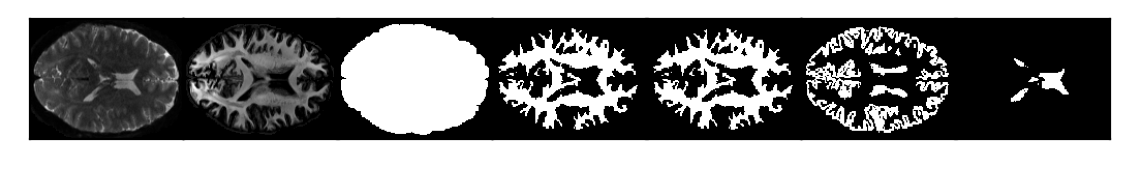

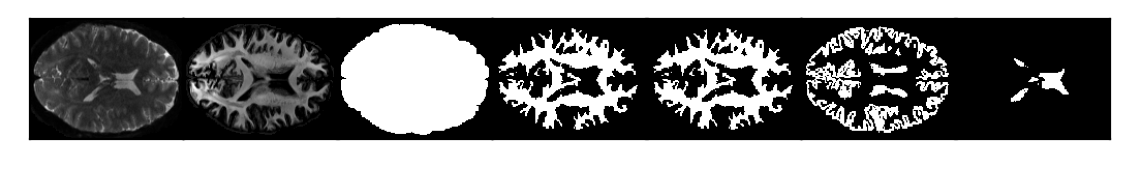

In [9]:
idx = (0, slice(None), slice(None), 60)
slices = [
    s["dwi"][idx],
    s["fodf"][idx],
    s["brain_mask"][idx],
    s["wm_mask"][idx],
    s["sampling_mask"][idx],
    s["gm_mask"][idx],
    s["csf_mask"][idx],
]

fig = plt.figure(dpi=200)
pitn.viz.plot_im_grid(slices, nrows=1, fig=fig, cmap="gray")

In [ ]:
1.25 / 2.0
1.25 / 2.5
1 / (2 * 1.0 / 1.25)
t1_blur = scipy.ndimage.gaussian_filter(t1, 0.5, truncate=3.0)
print(t1_blur.shape)
tf = monai.transforms.Spacing(
    (1.25, 1.25, 1.25),
    mode="bilinear",
    align_corners=True,
    scale_extent=True,
)
t1_resample = tf(t1_blur[None])
fig = plt.figure(dpi=200)
ic(t1.shape)
pitn.viz.plot_vol_slices(
    t1, slice_idx=(0.5, None, 0.5), fig=fig, interpolation="nearest"
)
plt.show()
fig = plt.figure(dpi=200)
t1_lin_resample = tf(t1[None])
ic(t1_lin_resample.shape)
pitn.viz.plot_vol_slices(
    t1_lin_resample, slice_idx=(0.5, None, 0.5), fig=fig, interpolation="nearest"
)
plt.show()
fig = plt.figure(dpi=200)
ic(t1_resample.shape)
pitn.viz.plot_vol_slices(
    t1_resample, slice_idx=(0.5, None, 0.5), fig=fig, interpolation="nearest"
);

In [ ]:
fig = plt.figure(dpi=300)
v = s["lr_dwi"][0:12:3].clone()
noisy_lr = monai.transforms.RandRicianNoise(
    prob=1.0,
    mean=0.0,
    std=10000 / 41,
    channel_wise=False,
    relative=False,
    sample_std=True,
)(v.clone())
pitn.viz.plot_vol_slices(
    v,
    noisy_lr,
    v - noisy_lr,
    slice_idx=(None, 0.4, 0.5),
    vol_labels=("orig", "orig+noise", "diff"),
    colorbars="cols",
    fig=fig,
    interpolation="nearest",
)
print(torch.median((v - noisy_lr).view(v.shape[0], -1), dim=1).values)

## Patches

In [209]:
patch_dataset = pitn.data.datasets2.HCPfODFINRPatchDataset(
    hcp_ds,
    patch_func=pitn.data.datasets2.HCPfODFINRPatchDataset.default_patch_func(
        spatial_size=(42, 42, 42),
        num_samples=3,
    ),
    samples_per_image=3,
    transform=pitn.data.datasets2.HCPfODFINRPatchDataset.default_feature_tf(
        baseline_iso_scale_factor_lr_spacing_mm_low_high=1.6,
        # augmentation_prob=0.0,
        augmentation_prob=1.0,
        augment_iso_scale_factor_lr_spacing_mm_low_high=(1.65, 2.0),
        # augment_rand_rotate_90_kwargs={"prob": 0.0},
        # augment_rand_flip_kwargs={"prob": 0.0},
        augment_rand_rician_noise_kwargs={"prob": 0.8},
    ),
)

ic| s["affine_vox2world"]: tensor([[  1.2500,   0.0000,   0.0000, -56.2500],
                                   [  0.0000,   1.2500,   0.0000,  -4.7500],
                                   [  0.0000,   0.0000,   1.2500,  -9.5000],
                                   [  0.0000,   0.0000,   0.0000,   1.0000]])
ic| s["affine_lr_vox2world"]: tensor([[  2.3155,   0.0000,   0.0000, -59.5789],
                                      [  0.0000,   2.3155,   0.0000,  -8.0789],
                                      [  0.0000,   0.0000,   2.3155, -12.8289],
                                      [  0.0000,   0.0000,   0.0000,   1.0000]])
ic| s["fodf"].shape: torch.Size([45, 32, 32, 32])
ic| s["lr_dwi"].shape: torch.Size([99, 20, 20, 20])
ic| monai.data.utils.compute_shape_offset(
        (36, 36, 36), s["affine_vox2world"], s["affine_lr_vox2world"]
    ): (array([20, 20, 20]), array([-56.25,  -4.75,  -9.5 ]))


(array([20, 20, 20]), array([-56.25,  -4.75,  -9.5 ]))

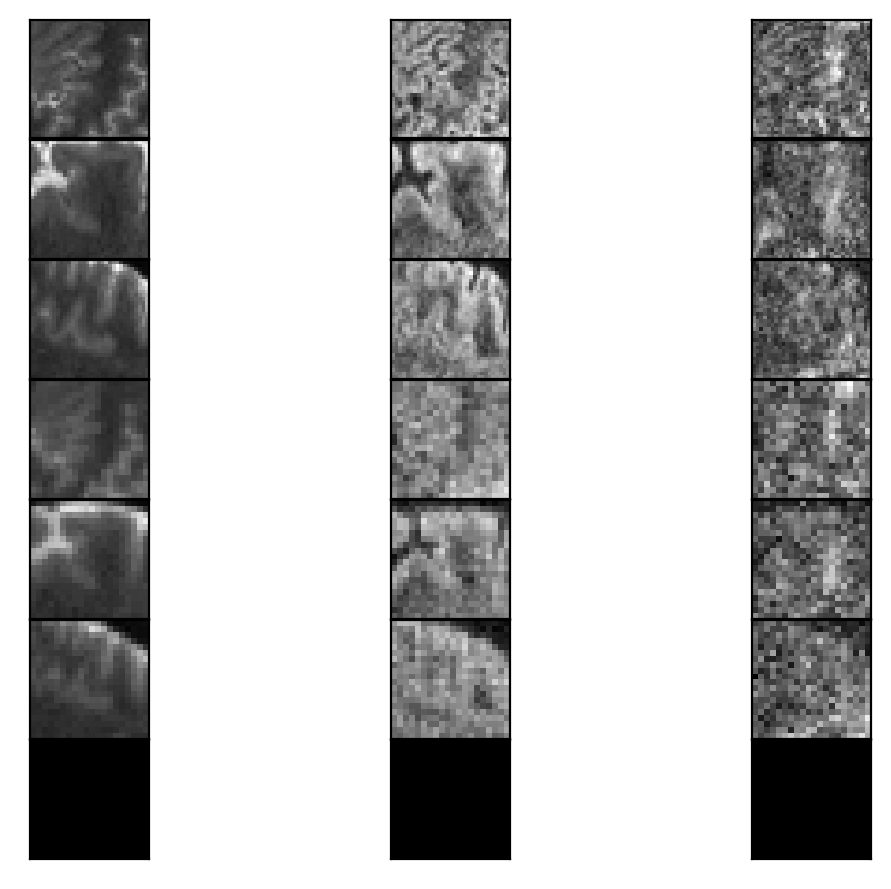

In [212]:
res = patch_dataset[1]
s = copy.deepcopy(res)

ic(s["affine_vox2world"])
ic(s["affine_lr_vox2world"])
ic(s["fodf"].shape)
ic(s["lr_dwi"].shape)
fig = plt.figure(dpi=200)
pitn.viz.plot_vol_slices(
    s["fodf"][0:3],
    s["lr_dwi"][0:3],
    # s["brain_mask"],
    s["lr_brain_mask"],
    # s["wm_mask"],
    # s["gm_mask"],
    fig=fig,
    cmap="gray",
    colorbars="cols",
    interpolation="nearest",
)
ic(
    monai.data.utils.compute_shape_offset(
        (36, 36, 36), s["affine_vox2world"], s["affine_lr_vox2world"]
    )
)

In [ ]:
src_v = s["dwi"]
target_v = s["lr_dwi"]
src_grid = pitn.affine.affine_coordinate_grid(s["affine_vox2world"], src_v.shape[1:])
target_grid = pitn.affine.affine_coordinate_grid(
    s["affine_lr_vox2world"], target_v.shape[1:]
)

pred_v = pitn.affine.sample_vol(
    src_v,
    target_grid,
    s["affine_vox2world"],
    align_corners=True,
    mode="linear",
    padding_mode="zeros",
    # override_out_of_bounds_val=-30000.0,
)

plt.figure(dpi=200)
pitn.viz.plot_vol_slices(
    pred_v[0:4],
    target_v[0:4],
    pred_v[0:4] - target_v[0:4],
    interpolation="nearest",
    colorbars="each",
);

In [213]:
g = pitn.affine.affine_coordinate_grid(
    s["affine_vox2world"], tuple(s["fodf"].shape[1:])
)
ic(g[0, 0, 0], g[-1, -1, -1])
ic(g[-1, -1, -1] - g[0, 0, 0])
ic(
    g[..., 0].min(),
    g[..., 1].min(),
    g[..., 2].min(),
    g[..., 0].max(),
    g[..., 1].max(),
    g[..., 2].max(),
)

g_lr = pitn.affine.affine_coordinate_grid(
    s["affine_lr_vox2world"], tuple(s["lr_dwi"].shape[1:])
)
ic(g_lr[0, 0, 0], g_lr[-1, -1, -1])
ic(g_lr[-1, -1, -1] - g_lr[0, 0, 0])
ic(
    g_lr[..., 0].min(),
    g_lr[..., 1].min(),
    g_lr[..., 2].min(),
    g_lr[..., 0].max(),
    g_lr[..., 1].max(),
    g_lr[..., 2].max(),
)

# LR should always be > FR by >= 1.25mm on each side.
ic(
    g_lr[0, 0, 0] - g[0, 0, 0],
    g_lr[-1, -1, -1] - g[-1, -1, -1],
)

ic| g[0, 0, 0]: tensor([-56.2500,  -4.7500,  -9.5000])
    g[-1, -1, -1]: tensor([-17.5000,  34.0000,  29.2500])
ic| g[-1, -1, -1] - g[0, 0, 0]: tensor([38.7500, 38.7500, 38.7500])
ic| g[..., 0].min(): tensor(-56.2500)
    g[..., 1].min(): tensor(-4.7500)
    g[..., 2].min(): tensor(-9.5000)
    g[..., 0].max(): tensor(-17.5000)
    g[..., 1].max(): tensor(34.)
    g[..., 2].max(): tensor(29.2500)
ic| g_lr[0, 0, 0]: tensor([-59.5789,  -8.0789, -12.8289])
    g_lr[-1, -1, -1]: tensor([-15.5852,  35.9148,  31.1648])
ic| g_lr[-1, -1, -1] - g_lr[0, 0, 0]: tensor([43.9937, 43.9937, 43.9937])
ic| g_lr[..., 0].min(): tensor(-59.5789)
    g_lr[..., 1].min(): tensor(-8.0789)
    g_lr[..., 2].min(): tensor(-12.8289)
    g_lr[..., 0].max(): tensor(-15.5852)
    g_lr[..., 1].max(): tensor(35.9148)
    g_lr[..., 2].max(): tensor(31.1648)
ic| g_lr[0, 0, 0] - g[0, 0, 0]: tensor([-3.3289, -3.3289, -3.3289])
    g_lr[-1, -1, -1] - g[-1, -1, -1]: tensor([1.9148, 1.9148, 1.9148])


(tensor([-3.3289, -3.3289, -3.3289]), tensor([1.9148, 1.9148, 1.9148]))

affine_vox2world torch.Size([4, 4]) torch.float32
affine_lr_vox2world torch.Size([4, 4]) torch.float32
vox_size torch.Size([3]) torch.float64
lr_vox_size torch.Size([3]) torch.float64
csf_mask torch.Size([1, 31, 31, 31]) torch.uint8
gm_mask torch.Size([1, 31, 31, 31]) torch.uint8
wm_mask torch.Size([1, 31, 31, 31]) torch.uint8
fodf torch.Size([45, 31, 31, 31]) torch.float32
brain_mask torch.Size([1, 31, 31, 31]) torch.uint8
lr_dwi torch.Size([99, 20, 20, 20]) torch.float32
lr_brain_mask torch.Size([1, 20, 20, 20]) torch.float32
tensor([[  1.2500,   0.0000,   0.0000, -25.0000],
        [  0.0000,   1.2500,   0.0000, -29.7500],
        [  0.0000,   0.0000,   1.2500,   1.7500],
        [  0.0000,   0.0000,   0.0000,   1.0000]])
tensor([[  2.2026,   0.0000,   0.0000, -27.2312],
        [  0.0000,   2.2026,   0.0000, -31.9812],
        [  0.0000,   0.0000,   2.2026,  -0.4812],
        [  0.0000,   0.0000,   0.0000,   1.0000]])


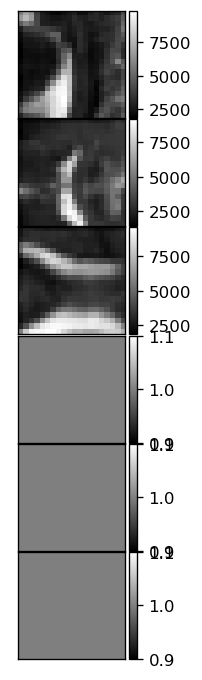

In [24]:
res = patch_dataset[1]
s = copy.deepcopy(res)
for k, v in s.items():
    if torch.is_tensor(v):
        print(k, v.shape, v.dtype)
print(s["affine_vox2world"])
print(s["affine_lr_vox2world"])
idx = (0, slice(None), slice(None), 10)

fig = plt.figure(dpi=120)
pitn.viz.plot_vol_slices(
    s["lr_dwi"][0], s["lr_brain_mask"][0], fig=fig, cmap="gray", colorbars="each"
);